In [22]:
import json
import pandas as pd
import dash
from dash import dcc, html, dash_table

In [23]:
NUM_AIRPLANES = {
    "airland1.txt": 10,
    "airland2.txt": 15,
    "airland3.txt": 20,
    "airland4.txt": 20,
    "airland5.txt": 20,
    "airland6.txt": 30,
    "airland7.txt": 44,
    "airland8.txt": 50,
    "airland9.txt": 100,
    "airland10.txt": 150,
    "airland11.txt": 200,
    "airland12.txt": 250,
    "airland13.txt": 500
}

def load_metrics_json(path: str) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def build_metrics_table(metrics_data: dict, num_airplanes: dict) -> pd.DataFrame:
    rows = []

    for solver, records in metrics_data.items():
        for rec in records:
            file = rec.get("file", "unknown")
            n_planes = num_airplanes.get(file, "—")
            num_runways = rec.get("num_runways", 1)
            strategy = rec.get("strategy", "—")

            exec_time = (
                rec.get("execution_time") or
                rec.get("total_time") or
                rec.get("cp_time") or
                rec.get("mip_time") or
                None
            )

            memory = (
                rec.get("memory_usage_MB") or
                rec.get("memory_usage") or
                rec.get("memory_start_MB") or
                None
            )

            penalty = (
                rec.get("total_penalty") or
                rec.get("best_objective_bound") or
                rec.get("total_best_objective_bound")
            )
            if penalty is not None:
                penalty = round(penalty)

            num_vars = rec.get("num_variables") or rec.get("cp_num_variables")
            num_cons = rec.get("num_constraints") or rec.get("cp_num_constraints")

            num_branches = (
                rec.get("num_branch_and_bound_nodes") or
                rec.get("num_branches") or
                rec.get("cp_num_branches")
            )

            row = {
                "Dataset": file,
                "#Planes": n_planes,
                "#Runways": num_runways,
                "Solver": solver,
                "Strategy": strategy,
                "Time (s)": exec_time,
                "Memory (MB)": memory,
                "Penalty / Obj": penalty,
                "#Variables": num_vars,
                "#Constraints": num_cons,
                "#Branches": num_branches,
                "Converged": rec.get("converged", rec.get("solution_status", "—")),
                "Num Conflicts": rec.get("num_conflicts", rec.get("cp_num_conflicts", "—")),
                "Num Booleans": rec.get("num_booleans", rec.get("cp_num_booleans","—")),
                "Num Iterations": rec.get("num_iterations", "—"),
                "MIP Num Calls": rec.get("mip_num_calls", "—")
            }

            rows.append(row)

    df = pd.DataFrame(rows)

    df["Solver"] = df["Solver"].replace({
        "MIP Multiple Large Datasets": "MIP Multiple",
        "CP Multiple Large Datasets": "CP Multiple",
        "Hybrid Large Datasets": "Hybrid"
    })

    return df


# Metrics table

## Static

In [24]:
def group_dataset_rows(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    for col in ["Dataset", "#Planes"]:
        df[col] = df[col].where(df[col].ne(df[col].shift()), "")

    return df

def style_metrics_table(df: pd.DataFrame, dataset_order: list):
    df = df.copy()

    solver_order = ["MIP Single", "MIP Multiple", "CP Single", "CP Multiple", "Hybrid"]

    df["Dataset"] = pd.Categorical(
        df["Dataset"],
        categories=dataset_order,
        ordered=True
    )

    df["Solver"] = pd.Categorical(
        df["Solver"],
        categories=solver_order,
        ordered=True
    )

    df = df.sort_values(
        ["Dataset", "Solver", "#Runways"],
        kind="stable"
    )

    df["Dataset"] = df["Dataset"].astype(str)

    df = group_dataset_rows(df)

    # Styling
    return (
        df
        .style
        .format({
            "Time (s)": "{:.3f}",
            "Memory (MB)": "{:.3f}",
            "Penalty / Obj": "{:.2f}",
        })
        .set_properties(**{
            "text-align": "center",
            "font-size": "11pt",
            "color": "#333333",
        })
        .set_table_styles([
            {
                "selector": "th",
                "props": [
                    ("font-weight", "bold"),
                    ("background-color", "#024253"),
                    ("color", "white"),
                    ("text-align", "center"),
                    ("border", "1px solid #BDBDBD"),
                ],
            },
            {
                "selector": "td",
                "props": [
                    ("padding", "6px"),
                    ("background-color", "#ECEEEE"),
                    ("border", "1px solid #DDDDDD"),
                ],
            },
        ])
        .hide(axis="index")
    )

metrics_data = load_metrics_json("results/metrics.json")

df = build_metrics_table(metrics_data, NUM_AIRPLANES)

dataset_order = list(NUM_AIRPLANES.keys())

styled_df = style_metrics_table(df, dataset_order)
styled_df


Dataset,#Planes,#Runways,Solver,Strategy,Time (s),Memory (MB),Penalty / Obj,#Variables,#Constraints,#Branches,Converged,Num Conflicts,Num Booleans,Num Iterations,MIP Num Calls
airland1.txt,10,1,MIP Single,—,0.197,0.001,700.00,120,205,25.000000,—,—,—,—,—
,,1,MIP Multiple,—,0.218,0.007,700.00,220,395,21.000000,—,—,—,—,—
,,2,MIP Multiple,—,0.058,0.000,90.00,230,440,73.000000,—,—,—,—,—
,,3,MIP Multiple,—,0.082,0.000,nan,240,485,13.000000,—,—,—,—,—
,,1,CP Single,Automatic Search,0.018,0.008,700.00,75,130,nan,OPTIMAL,0,0,—,—
,,1,CP Single,Fixed Search,0.036,0.007,700.00,75,130,nan,OPTIMAL,0,0,—,—
,,1,CP Single,Portfolio Search,0.020,0.007,700.00,75,130,nan,OPTIMAL,0,0,—,—
,,1,CP Single,LP Search,0.026,0.007,700.00,75,130,26.000000,OPTIMAL,0,45,—,—
,,1,CP Multiple,Automatic Search,0.025,0.018,700.00,130,320,nan,OPTIMAL,0,45,—,—
,,1,CP Multiple,Fixed Search,0.025,0.018,700.00,130,320,98.000000,OPTIMAL,0,53,—,—


## With Filters

In [25]:
import dash
from dash import dcc, html, dash_table
import pandas as pd

metrics_data = load_metrics_json("results/metrics.json")
df = build_metrics_table(metrics_data, NUM_AIRPLANES)

solver_order = ["MIP Single", "MIP Multiple", "CP Single", "CP Multiple", "Hybrid"]
dataset_order = list(NUM_AIRPLANES.keys())

df["Dataset"] = pd.Categorical(df["Dataset"], categories=dataset_order, ordered=True)
df["Solver"] = pd.Categorical(df["Solver"], categories=solver_order, ordered=True)
df = df.sort_values(["Dataset", "Solver", "#Runways"], kind="stable").reset_index(drop=True)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H3("Interactive Metrics Table"),

    html.Div([
        html.Label("Filter by Dataset:"),
        dcc.Dropdown(
            id="dataset-filter",
            options=[{"label": d, "value": d} for d in dataset_order],
            multi=True,
            placeholder="Select dataset(s)"
        ),
    ], style={"width": "45%", "display": "inline-block", "padding-right": "20px"}),

    html.Div([
        html.Label("Filter by Solver:"),
        dcc.Dropdown(
            id="solver-filter",
            options=[{"label": s, "value": s} for s in solver_order],
            multi=True,
            placeholder="Select solver(s)"
        ),
    ], style={"width": "45%", "display": "inline-block"}),

    html.Br(),

    dash_table.DataTable(
        id="metrics-table",
        columns=[{"name": c, "id": c} for c in df.columns],
        data=df.to_dict("records"),
        style_cell={
            'textAlign': 'center',
            'padding': '5px',
            'minWidth': '80px',
            'width': '80px',
            'maxWidth': '200px',
            'whiteSpace': 'normal',
        },
        style_header={
            'backgroundColor': '#024253',
            'color': 'white',
            'fontWeight': 'bold',
            'textAlign': 'center'
        },
        style_data={'backgroundColor': '#ECEEEE', 'color': '#333333'},
        style_table={
            'overflowX': 'auto',
            'maxWidth': '100%',
            'border': '1px solid #DDDDDD'
        },
        page_size=20,
        sort_action="native",
    )
], style={"backgroundColor": "white", "padding": "20px"})

@app.callback(
    dash.dependencies.Output("metrics-table", "data"),
    [
        dash.dependencies.Input("dataset-filter", "value"),
        dash.dependencies.Input("solver-filter", "value"),
    ]
)
def update_table(selected_datasets, selected_solvers):
    filtered = df.copy()
    if selected_datasets:
        filtered = filtered[filtered["Dataset"].isin(selected_datasets)]
    if selected_solvers:
        filtered = filtered[filtered["Solver"].isin(selected_solvers)]

    numeric_cols = filtered.select_dtypes(include=["number"]).columns
    filtered[numeric_cols] = filtered[numeric_cols].fillna(0)

    return filtered.to_dict("records")


if __name__ == "__main__":
    app.run(debug=True)


# Plots

In [26]:
metrics_data = load_metrics_json("results/metrics.json")
NUM_AIRPLANES = {
    "airland1.txt": 10,
    "airland2.txt": 15,
    "airland3.txt": 20,
    "airland4.txt": 20,
    "airland5.txt": 20,
    "airland6.txt": 30,
    "airland7.txt": 44,
    "airland8.txt": 50,
    "airland9.txt": 100,
    "airland10.txt": 150,
    "airland11.txt": 200,
    "airland12.txt": 250,
    "airland13.txt": 500
}

df = build_metrics_table(metrics_data, NUM_AIRPLANES)

In [27]:
solver_colors = {"MIP": "#1f77b4", "CP": "#e961d0", "Hybrid": "#e69736"}
markers = {"MIP": "o", "CP": "s", "Hybrid": "^"}

# Compare CP, MIP and Hybrid

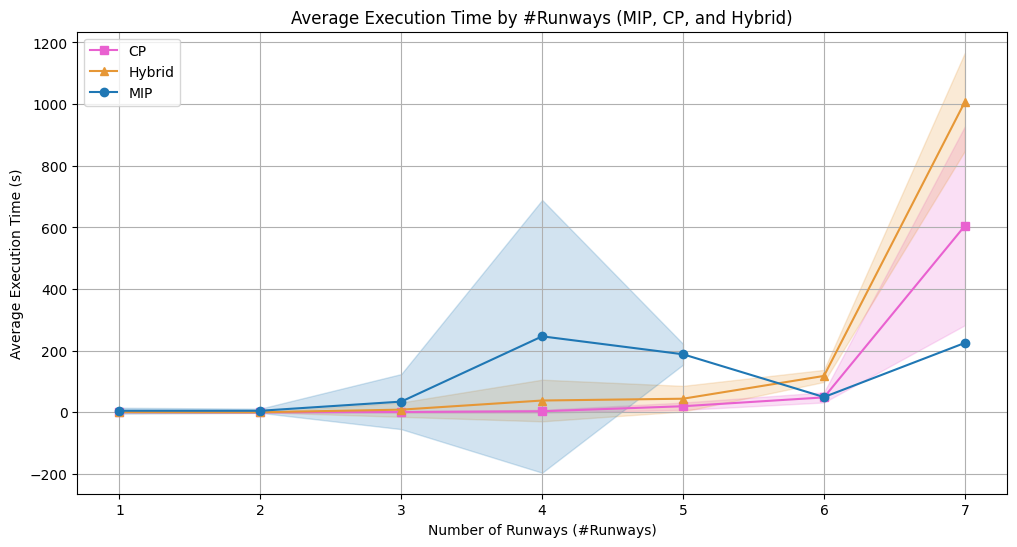

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter only solvers of interest and unify names
df_selected = df[df["Solver"].str.contains("MIP|CP|Hybrid")].copy()

df_selected["Solver"] = df_selected["Solver"].replace({
    "MIP Multiple Large Datasets": "MIP",
    "MIP Single": "MIP",
    "MIP Multiple": "MIP",
    "CP Multiple": "CP",
    "CP Single": "CP",
    "Hybrid Large Datasets": "Hybrid"
})

df_selected["#Planes"] = pd.to_numeric(df_selected["#Planes"])
df_selected["#Runways"] = pd.to_numeric(df_selected["#Runways"])

summary = df_selected.groupby(["Solver", "#Runways"]).agg(
    Time_mean=("Time (s)", "mean"),
    Time_std=("Time (s)", "std"),
    Penalty_mean=("Penalty / Obj", "mean"),
    Penalty_std=("Penalty / Obj", "std")
).reset_index()

solver_colors = {"MIP": "#1f77b4", "CP": "#e961d0", "Hybrid": "#e69736"}
markers = {"MIP": "o", "CP": "s", "Hybrid": "^"}

# Plot mean Time ± standard deviation
plt.figure(figsize=(12, 6))
for solver in summary["Solver"].unique():
    data = summary[summary["Solver"] == solver]
    plt.plot(data["#Runways"], data["Time_mean"], marker=markers[solver], label=solver, color=solver_colors[solver])
    plt.fill_between(
        data["#Runways"],
        data["Time_mean"] - data["Time_std"],
        data["Time_mean"] + data["Time_std"],
        alpha=0.2,
        color=solver_colors[solver]
    )

plt.xlabel("Number of Runways (#Runways)")
plt.ylabel("Average Execution Time (s)")
plt.title("Average Execution Time by #Runways (MIP, CP, and Hybrid)")
plt.grid(True)
plt.legend()
plt.show()


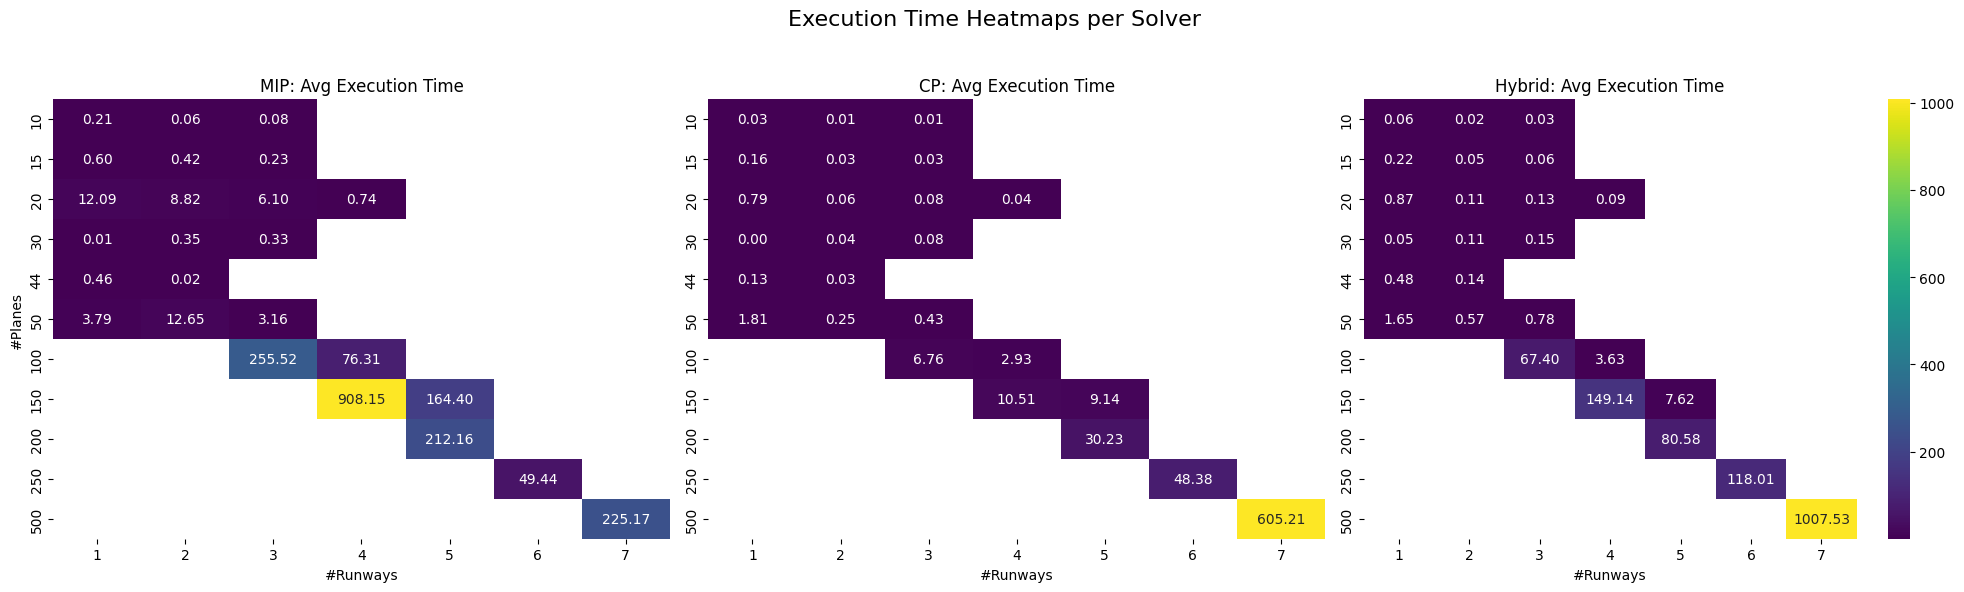

In [29]:
import seaborn as sns

solvers = ["MIP", "CP", "Hybrid"]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, solver in enumerate(solvers):
    data_solver = df_selected[df_selected["Solver"] == solver]
    pivot = data_solver.pivot_table(
        index="#Planes",
        columns="#Runways",
        values="Time (s)",
        aggfunc='mean'
    )
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        ax=axes[i],
        cbar=i == 2
    )
    axes[i].set_title(f"{solver}: Avg Execution Time")
    axes[i].set_xlabel("#Runways")
    if i == 0:
        axes[i].set_ylabel("#Planes")
    else:
        axes[i].set_ylabel("")

plt.suptitle("Execution Time Heatmaps per Solver", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


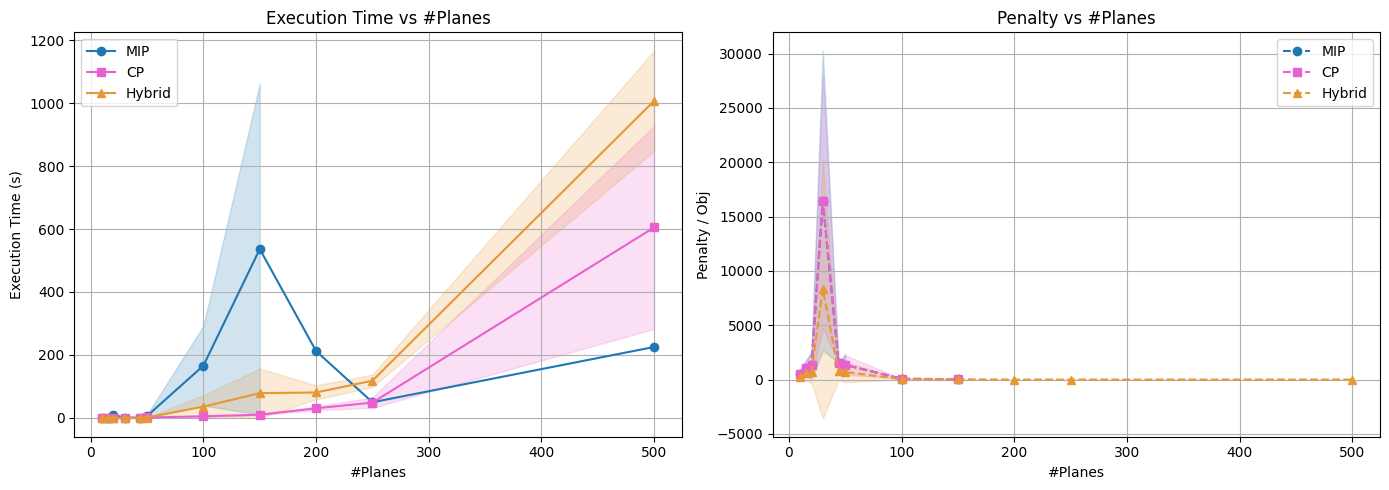

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

solver_colors = {"MIP": "#1f77b4", "CP": "#e961d0", "Hybrid": "#e69736"}
markers = {"MIP": "o", "CP": "s", "Hybrid": "^"}

for solver in ["MIP", "CP", "Hybrid"]:
    data_solver = df_selected[df_selected["Solver"] == solver]
    mean_time = data_solver.groupby("#Planes")["Time (s)"].mean()
    std_time = data_solver.groupby("#Planes")["Time (s)"].std()
    axes[0].plot(mean_time.index, mean_time.values, marker=markers[solver], label=solver, color =solver_colors[solver])
    axes[0].fill_between(mean_time.index, mean_time - std_time, mean_time + std_time, alpha=0.2,
                         color = solver_colors[solver])

    mean_penalty = data_solver.groupby("#Planes")["Penalty / Obj"].mean()
    std_penalty = data_solver.groupby("#Planes")["Penalty / Obj"].std()
    axes[1].plot(mean_penalty.index, mean_penalty.values, marker=markers[solver], linestyle='--', label=solver, color=solver_colors[solver])
    axes[1].fill_between(mean_penalty.index, mean_penalty - std_penalty, mean_penalty + std_penalty,
                         alpha=0.2,
                         color = solver_colors[solver])

axes[0].set_xlabel("#Planes")
axes[0].set_ylabel("Execution Time (s)")
axes[0].set_title("Execution Time vs #Planes")
axes[0].grid(True)
axes[0].legend()

axes[1].set_xlabel("#Planes")
axes[1].set_ylabel("Penalty / Obj")
axes[1].set_title("Penalty vs #Planes")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


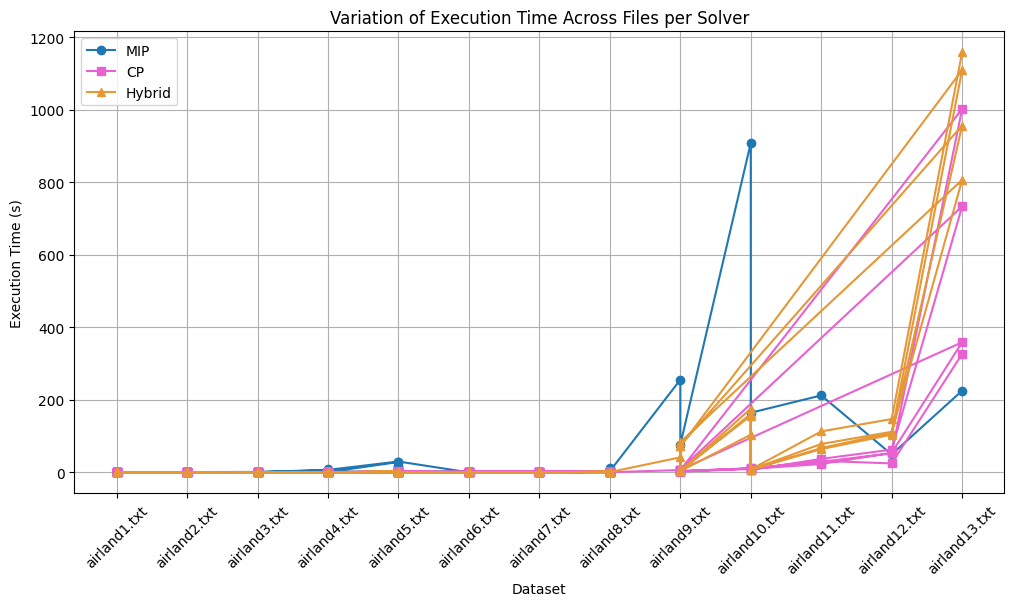

In [31]:
plt.figure(figsize=(12, 6))
for solver in df_selected["Solver"].unique():
    data = df_selected[df_selected["Solver"] == solver]
    plt.plot(data["Dataset"],
             data["Time (s)"],
             marker=markers[solver],
             linestyle='-',
             label=solver,
             color=solver_colors[solver])

plt.xlabel("Dataset")
plt.ylabel("Execution Time (s)")
plt.title("Variation of Execution Time Across Files per Solver")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


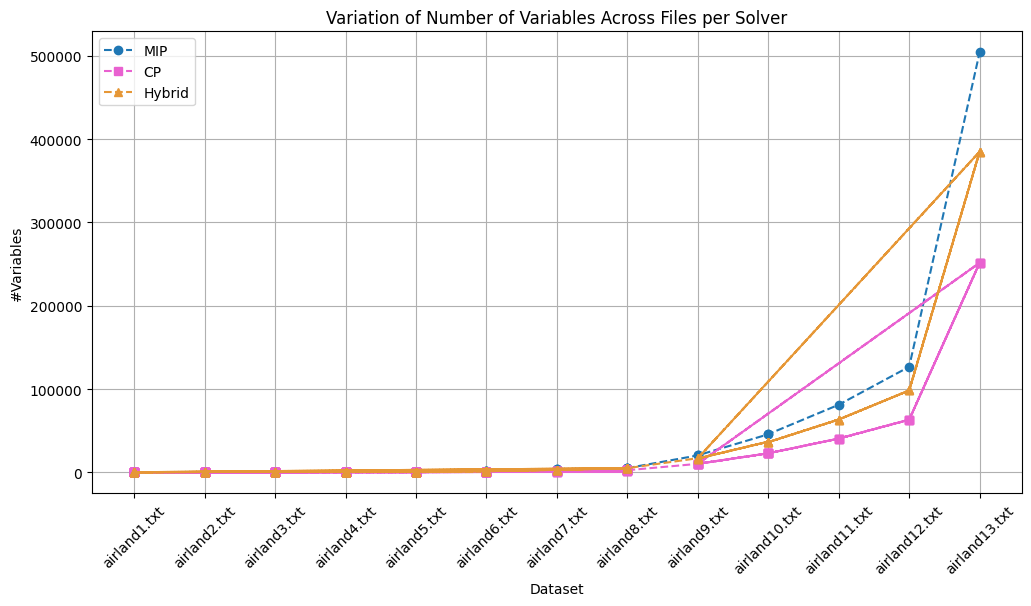

In [32]:
plt.figure(figsize=(12, 6))
for solver in df_selected["Solver"].unique():
    data = df_selected[df_selected["Solver"] == solver]
    plt.plot(data["Dataset"], data["#Variables"], marker=markers[solver], linestyle='--', label=solver, color=solver_colors[solver])

plt.xlabel("Dataset")
plt.ylabel("#Variables")
plt.title("Variation of Number of Variables Across Files per Solver")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


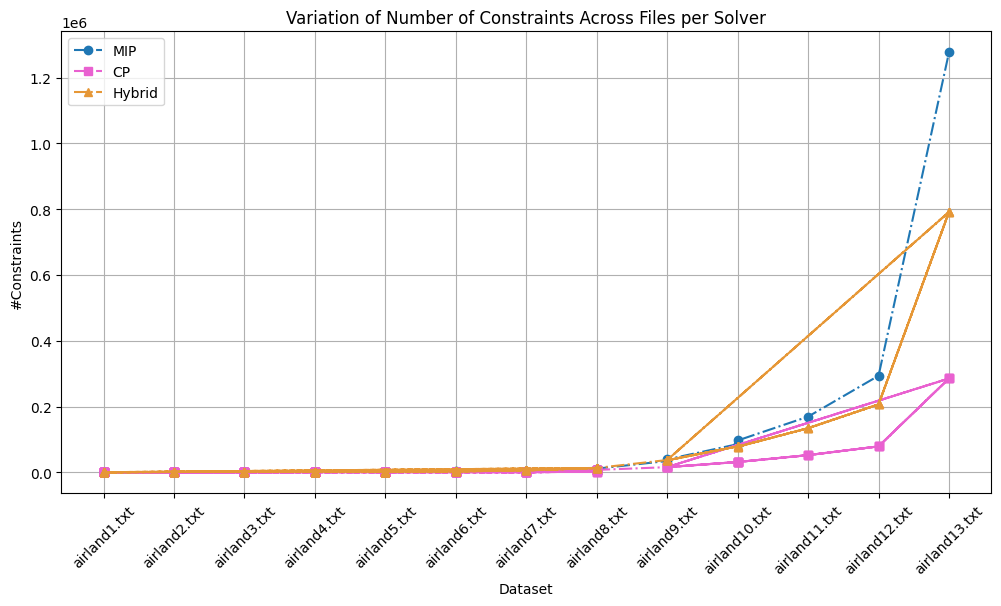

In [33]:
plt.figure(figsize=(12, 6))
for solver in df_selected["Solver"].unique():
    data = df_selected[df_selected["Solver"] == solver]
    plt.plot(data["Dataset"], data["#Constraints"], marker=markers[solver], linestyle='-.', label=solver, color=solver_colors[solver])

plt.xlabel("Dataset")
plt.ylabel("#Constraints")
plt.title("Variation of Number of Constraints Across Files per Solver")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


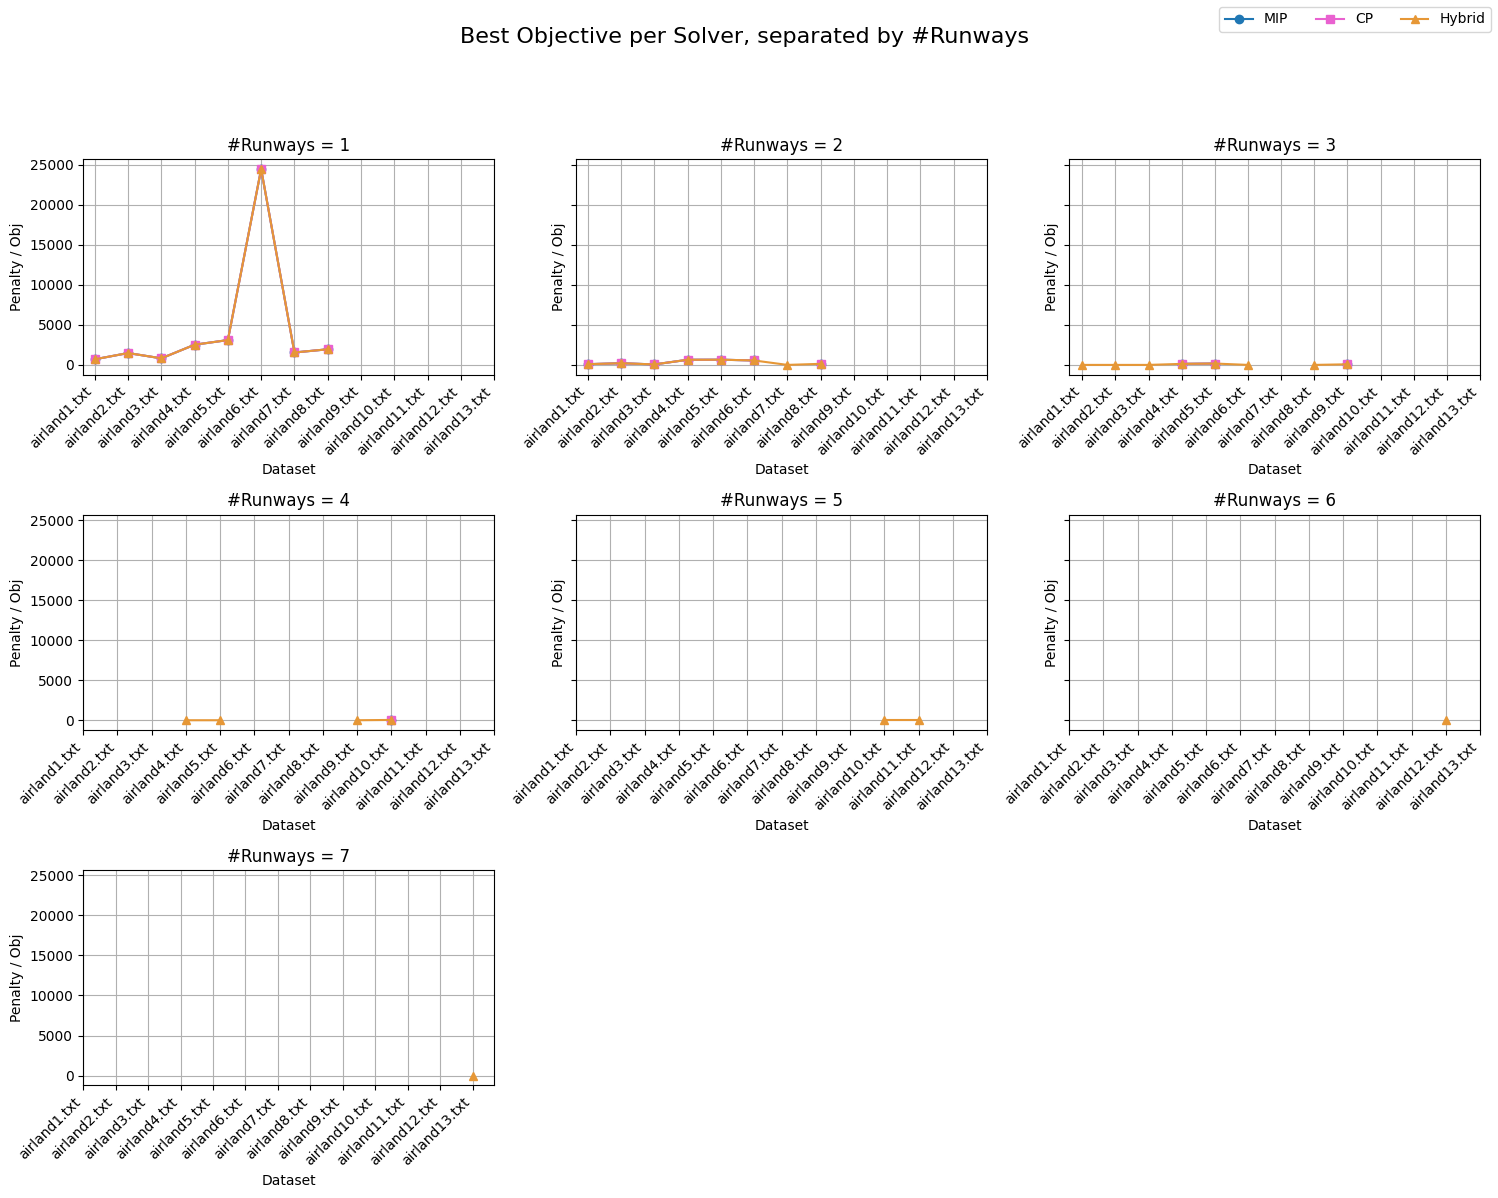

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import re

solver_colors = {"MIP": "#1f77b4", "CP": "#e961d0", "Hybrid": "#e69736"}
markers = {"MIP": "o", "CP": "s", "Hybrid": "^"}

unique_runways = sorted(df_selected["#Runways"].dropna().unique())
n_runways = len(unique_runways)

def dataset_sort_key(name):
    m = re.search(r"airland(\d+)", name)
    return int(m.group(1)) if m else 0

cols = 3
rows = (n_runways + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), sharey=True)

axes = axes.flatten()

for i, runways in enumerate(unique_runways):
    ax = axes[i]
    subset_runway = df_selected[df_selected["#Runways"] == runways]

    datasets = sorted(df_selected["Dataset"].unique(), key=dataset_sort_key)
    x = np.arange(len(datasets))

    for solver in subset_runway["Solver"].unique():
        sub = subset_runway[subset_runway["Solver"] == solver]
        y = [sub[sub["Dataset"]==d]["Penalty / Obj"].values[0] if d in sub["Dataset"].values else np.nan for d in datasets]
        ax.plot(x, y,
                marker=markers[solver],
                linestyle='-',
                color=solver_colors[solver],
                label=solver)

    ax.set_title(f"#Runways = {runways}")
    ax.set_xlabel("Dataset")
    ax.set_ylabel("Penalty / Obj")
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha="right")
    ax.grid(True)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, fontsize=10)

plt.suptitle("Best Objective per Solver, separated by #Runways", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()



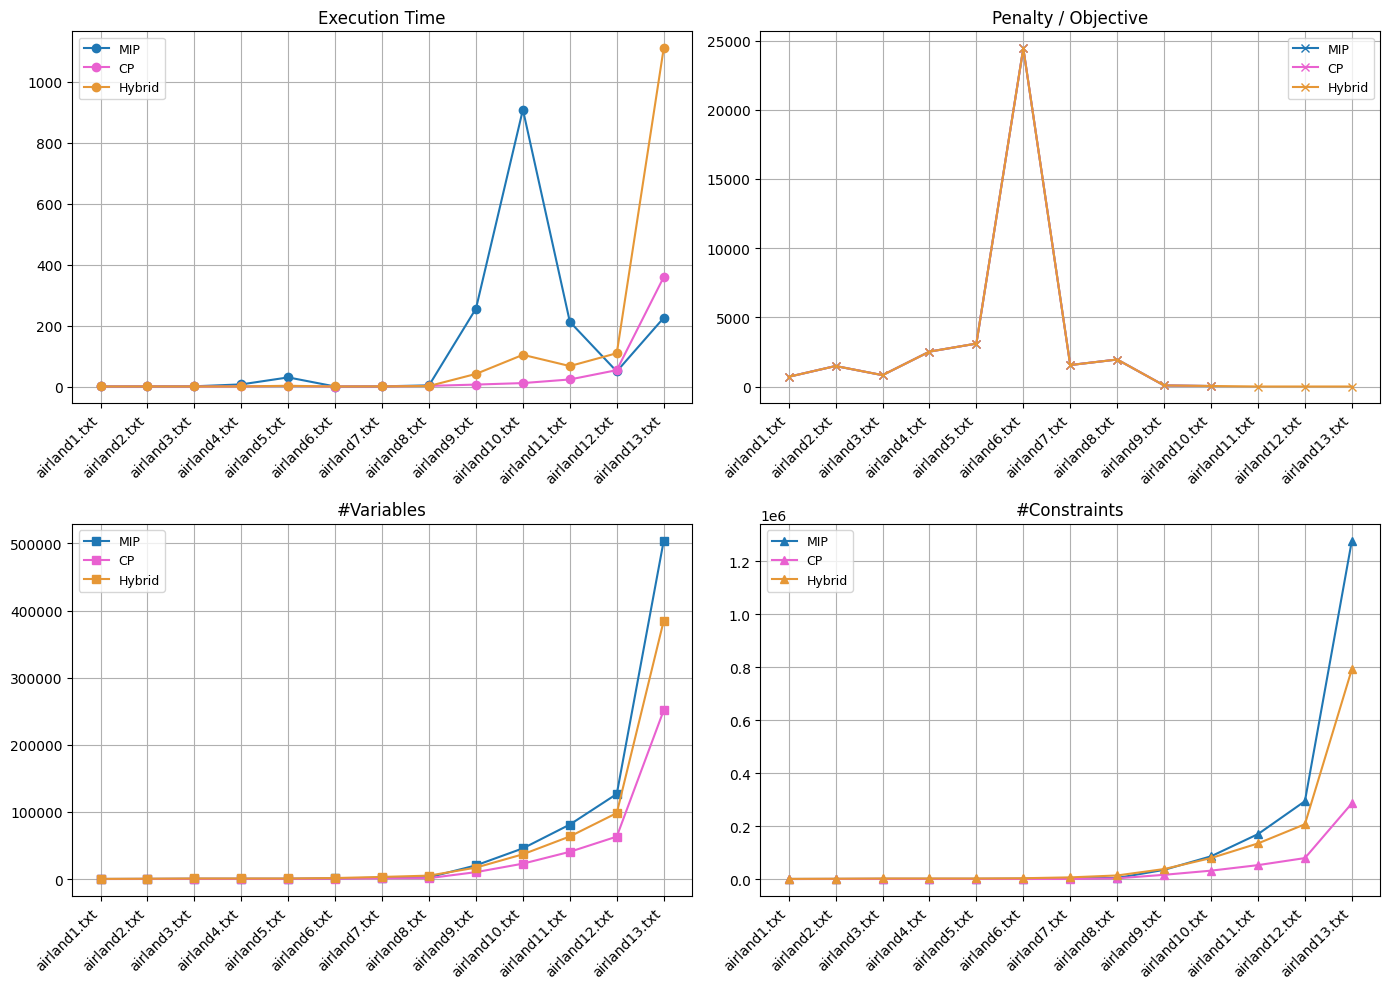

In [35]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ["Time (s)", "Penalty / Obj", "#Variables", "#Constraints"]
titles = ["Execution Time", "Penalty / Objective", "#Variables", "#Constraints"]
markers = ['o', 'x', 's', '^']

datasets = sorted(df_selected["Dataset"].unique(), key=dataset_sort_key)
df_selected["Solver"] = df_selected["Solver"].replace({
    "MIP Multiple Large Datasets": "MIP",
    "MIP Single": "MIP",
    "MIP Multiple": "MIP",
    "CP Multiple": "CP",
    "CP Single": "CP",
    "Hybrid Large Datasets": "Hybrid"
})
x = np.arange(len(datasets))

def dataset_sort_key(name):
    m = re.search(r"airland(\d+)", name)
    return int(m.group(1)) if m else 0

for ax, metric, title, marker in zip(axes.flatten(), metrics, titles, markers):
    for solver in df_selected["Solver"].unique():
        data = df_selected[df_selected["Solver"] == solver]
        y = [data[data["Dataset"]==d][metric].values[0] if d in data["Dataset"].values else np.nan for d in datasets]
        ax.plot(x, y, marker=marker, linestyle='-', label=solver, color=solver_colors[solver])

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha="right")
    ax.grid(True)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


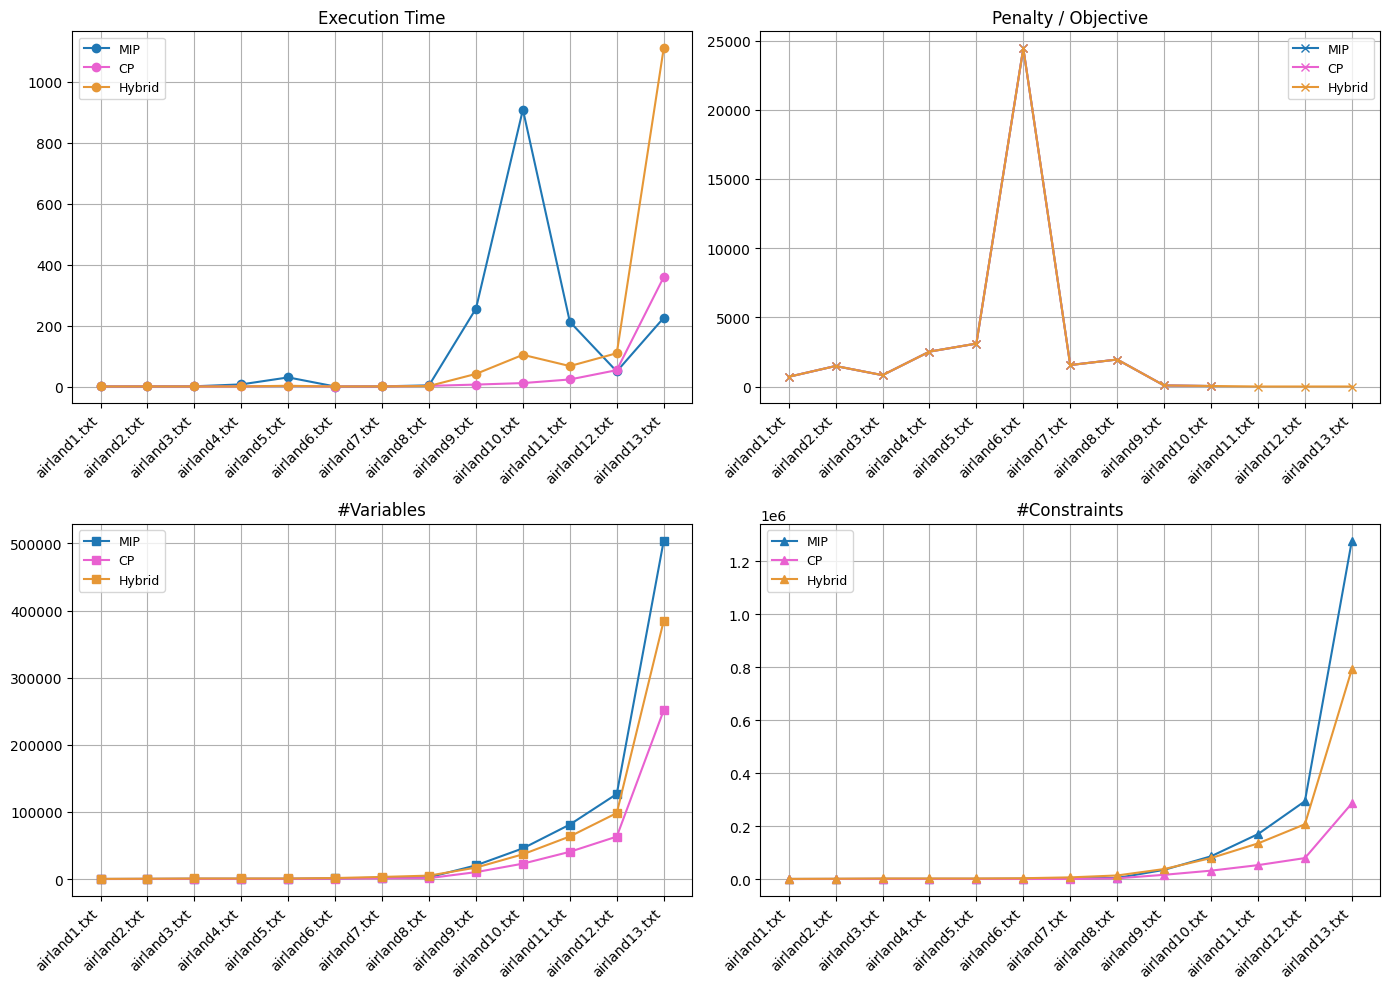

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import re

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ["Time (s)", "Penalty / Obj", "#Variables", "#Constraints"]
titles = ["Execution Time", "Penalty / Objective", "#Variables", "#Constraints"]
markers = ['o', 'x', 's', '^']

# Substituir nomes de solver
df_selected["Solver"] = df_selected["Solver"].replace({
    "MIP Multiple Large Datasets": "MIP",
    "MIP Single": "MIP",
    "MIP Multiple": "MIP",
    "CP Multiple": "CP",
    "CP Single": "CP",
    "Hybrid Large Datasets": "Hybrid"
})

# Ordenação numérica dos datasets
def dataset_sort_key(name):
    m = re.search(r"airland(\d+)", name)
    return int(m.group(1)) if m else 0

datasets = sorted(df_selected["Dataset"].unique(), key=dataset_sort_key)
x = np.arange(len(datasets))  # posições numéricas

for ax, metric, title, marker in zip(axes.flatten(), metrics, titles, markers):
    for solver in df_selected["Solver"].unique():
        data = df_selected[df_selected["Solver"] == solver]
        # alinhamento dos valores com o x numérico
        y = [data[data["Dataset"]==d][metric].values[0] if d in data["Dataset"].values else np.nan for d in datasets]
        ax.plot(x, y, marker=marker, linestyle='-', label=solver, color=solver_colors[solver])

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha="right")
    ax.grid(True)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()



# CP

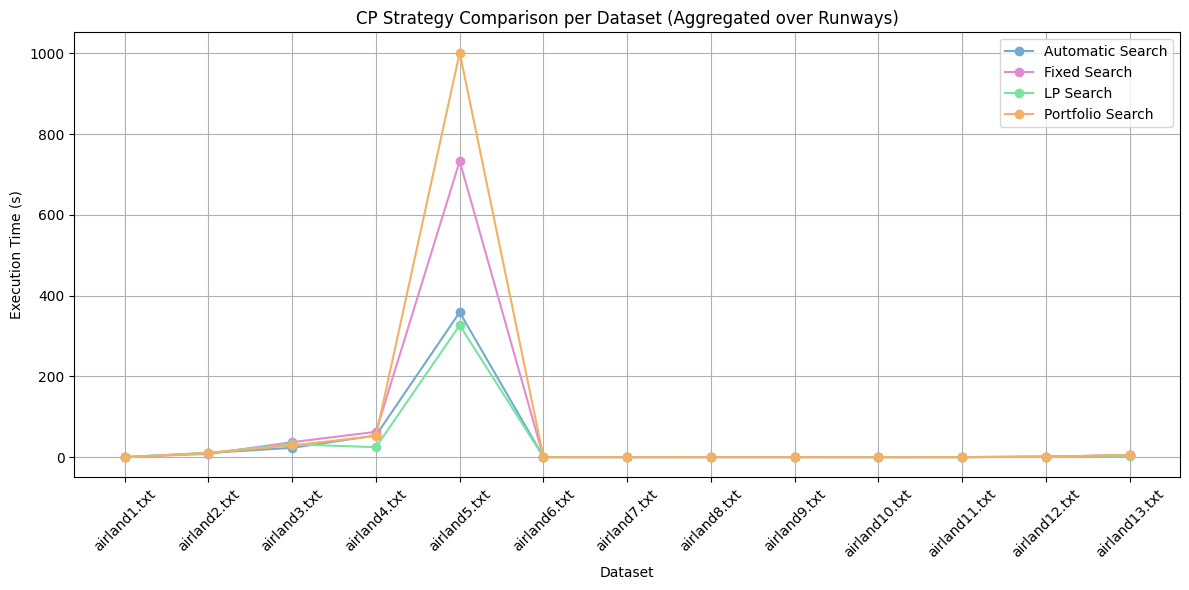

In [44]:
import matplotlib.pyplot as plt

cp_data = df_selected[df_selected["Solver"] == "CP"]

df_ds_strategy = (
    cp_data
    .groupby(["Dataset", "Strategy"])["Time (s)"]
    .median()   # ou .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))

def dataset_sort_key(name):
    m = re.search(r"airland(\d+)", name)
    return int(m.group(1)) if m else 0

datasets = sorted(df_selected["Dataset"].unique(), key=dataset_sort_key)

for strategy in df_ds_strategy["Strategy"].unique():
    subset = df_ds_strategy[df_ds_strategy["Strategy"] == strategy]
    plt.plot(
        datasets,
        subset["Time (s)"],
        marker="o",
        label=strategy,
        color=strategy_colors[strategy]
    )

plt.xlabel("Dataset")
plt.ylabel("Execution Time (s)")
plt.title("CP Strategy Comparison per Dataset (Aggregated over Runways)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


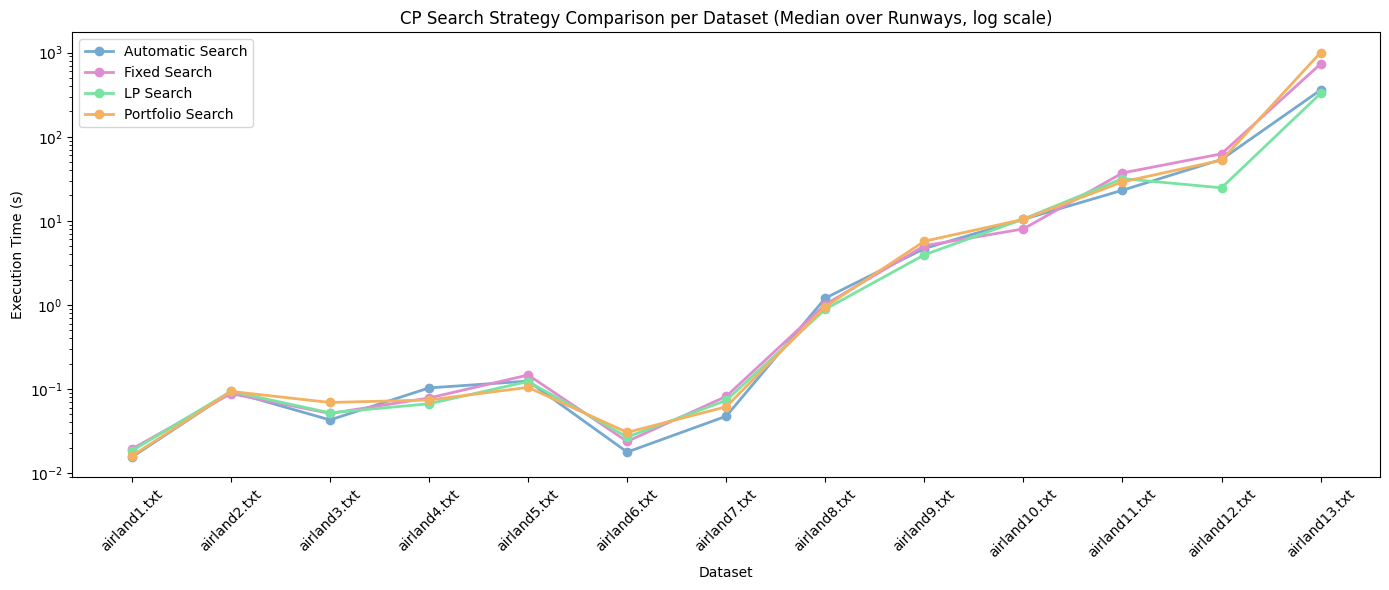

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import re

solver_colors = {"MIP": "#1f77b4", "CP": "#e961d0", "Hybrid": "#e69736"}
markers = {"MIP": "o", "CP": "s", "Hybrid": "^"}
strategy_colors = {"Automatic Search": "#75a9cf",
                   "Fixed Search": "#e18cd1",
                   "Portfolio Search": "#f3b161",
                   "LP Search": "#79e4a2"}

# Filtrar CP
cp_data = df_selected[df_selected["Solver"] == "CP"]

# Agregar por Dataset + Strategy (mediana sobre runways)
df_ds_strategy = (
    cp_data
    .groupby(["Dataset", "Strategy"])["Time (s)"]
    .median()
    .reset_index()
)

# Ordenar datasets (airland1, airland2, ...)
def dataset_sort_key(name):
    m = re.search(r"airland(\d+)", name)
    return int(m.group(1)) if m else 0

datasets = sorted(df_ds_strategy["Dataset"].unique(), key=dataset_sort_key)
strategies = df_ds_strategy["Strategy"].unique()

x = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(14, 6))

for strategy in strategies:
    strat_data = (
        df_ds_strategy[df_ds_strategy["Strategy"] == strategy]
        .set_index("Dataset")
        .reindex(datasets)
    )

    ax.plot(
        x,
        strat_data["Time (s)"],
        marker="o",
        linewidth=2,
        label=strategy,
        color=strategy_colors[strategy]
    )

# Log scale
ax.set_yscale("log")

ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)

ax.set_xlabel("Dataset")
ax.set_ylabel("Execution Time (s)")
ax.set_title("CP Search Strategy Comparison per Dataset (Median over Runways, log scale)")

ax.legend()
ax.grid(True, which="both", linestyle="", alpha=0.6)

fig.tight_layout()
plt.show()


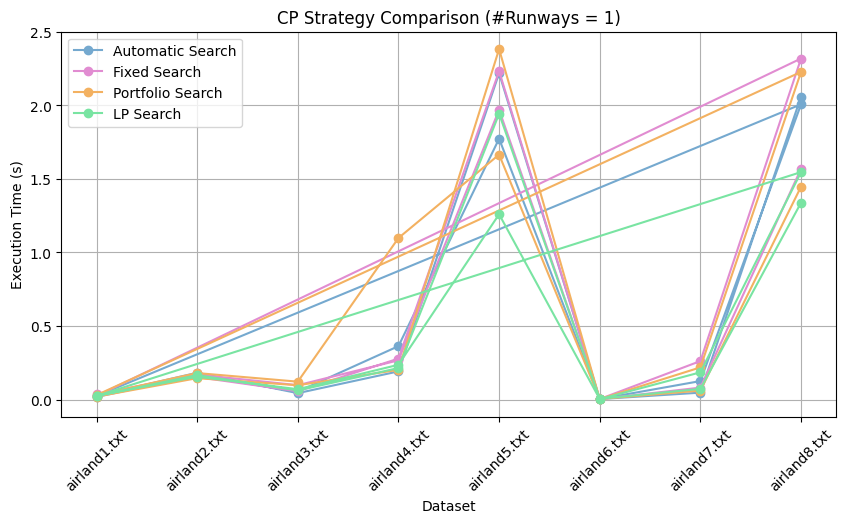

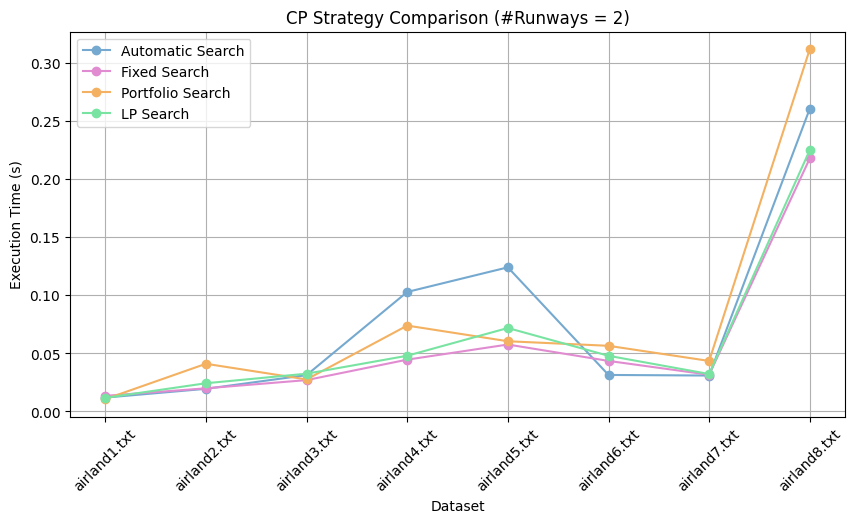

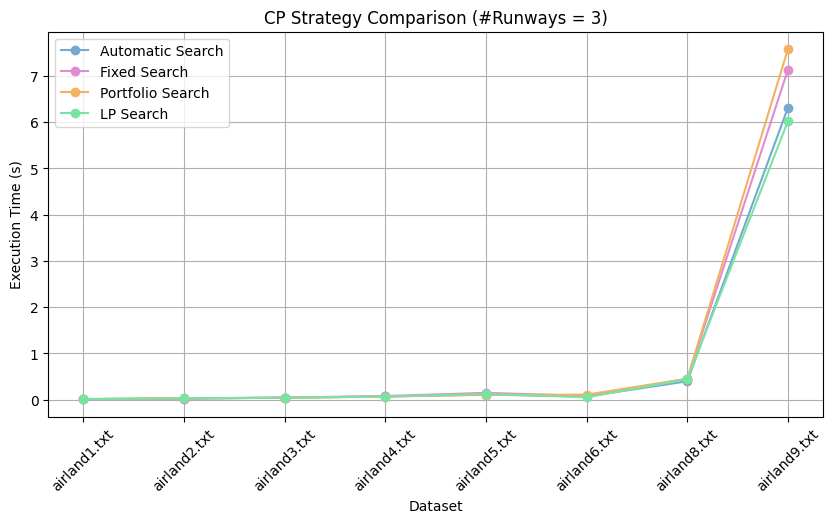

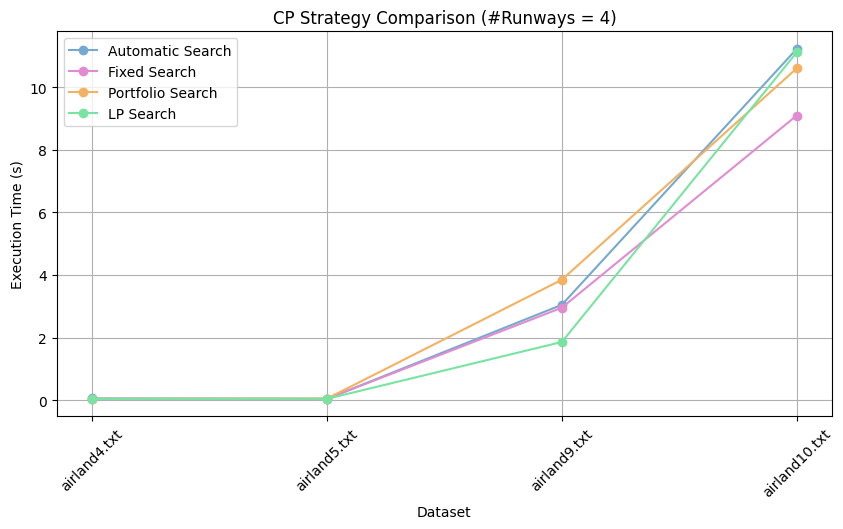

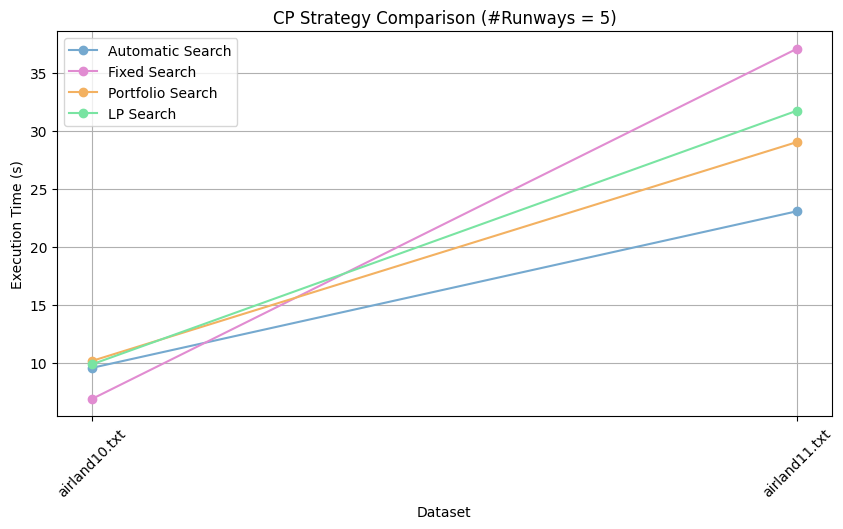

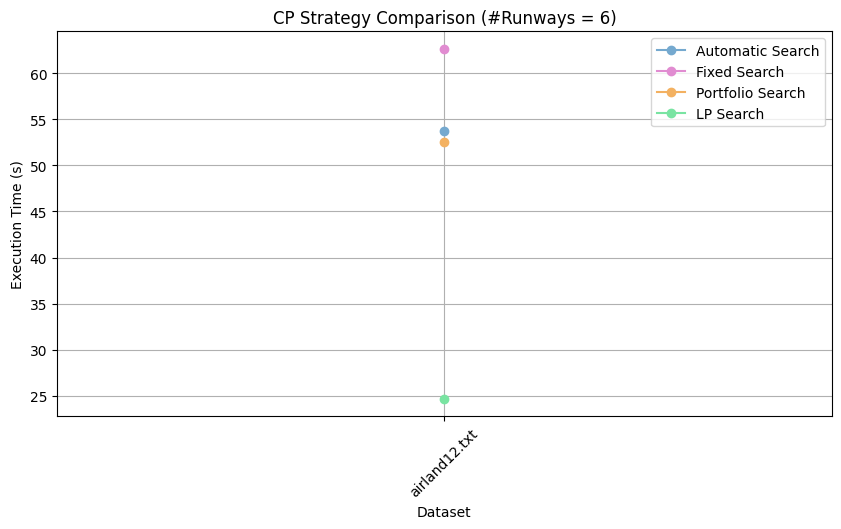

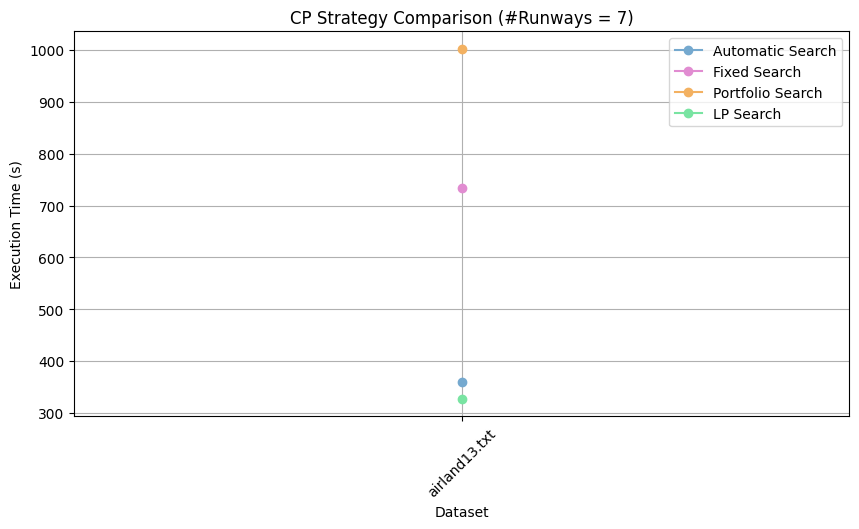

In [ ]:
solver_colors = {"MIP": "#1f77b4", "CP": "#e961d0", "Hybrid": "#e69736"}
markers = {"MIP": "o", "CP": "s", "Hybrid": "^"}
strategy_colors = {"Automatic Search": "#75a9cf",
                   "Fixed Search": "#e18cd1",
                   "Portfolio Search": "#f3b161",
                   "LP Search": "#79e4a2"}

df_selected["Solver"] = df_selected["Solver"].replace({
    "MIP Multiple Large Datasets": "MIP",
    "MIP Single": "MIP",
    "MIP Multiple": "MIP",
    "CP Multiple": "CP",
    "CP Single": "CP",
    "Hybrid Large Datasets": "Hybrid"
})

cp_data = df_selected[df_selected["Solver"] == "CP"]

# Single vs Multi Runway
for runways in sorted(cp_data["#Runways"].unique()):
    subset = cp_data[cp_data["#Runways"] == runways]
    plt.figure(figsize=(10, 5))
    for strategy in subset["Strategy"].unique():
        strat_data = subset[subset["Strategy"] == strategy]
        plt.plot(strat_data["Dataset"], strat_data["Time (s)"], marker='o', label=strategy, color =strategy_colors[strategy])
    plt.xlabel("Dataset")
    plt.ylabel("Execution Time (s)")
    plt.title(f"CP Strategy Comparison (#Runways = {runways})")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()
